In [629]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import tensorflow as tf
from keras.layers import TFSMLayer

In [630]:
# reduced pixel size 
pixel_size=32*9
higher_pixel_size=32*9
multiplying_factor=higher_pixel_size/pixel_size

image process

In [631]:
def imagePreProcess(imagepath,pixel_size=64*9):
    #image must be in greyscale
    #resize image with reduced pixel
    image = cv2.imread(imagepath,cv2.IMREAD_GRAYSCALE)
    image=cv2.resize(image,[pixel_size,pixel_size])
    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,1)
    image=cv2.GaussianBlur(image,(3,3),1)
    return image


In [632]:
def findContourPoints(image):
    image = cv2.bitwise_not(image)
    contours, hierarchy = cv2.findContours(image,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max=0
    for i in contours:
        if(cv2.contourArea(i)>50):
            peri=cv2.arcLength(i,True)
            approx=cv2.approxPolyDP(i,0.02*peri,True)
            if(len(approx)==4):
                if(cv2.contourArea(approx)>max):
                    bigcontour=approx
                    
    bigcontour=bigcontour.T
    bigcontour[0]=bigcontour[0][0]
    bigcontour[1]=bigcontour[1][0]
    cv2.drawContours(image, contours, -1, (0, 255, 0), 1)
    plt.imshow(image,cmap='gray')
    plt.scatter(bigcontour[0],bigcontour[1],color='r')
    return np.array(list(zip(list(bigcontour[0][0]),list(bigcontour[1][0]))))

In [633]:
def imageWrape(image,contour):
    contour = np.array(contour, dtype=np.float32)
    dest_points = np.array([(0, 0), (0, len(image)),(len(image), len(image)),(len(image),0)],dtype=np.float32)
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(contour,dest_points)
    sudoku_img_bit= cv2.warpPerspective(image, matrix,(len(image),len(image)))

    #cliping
    clipped_image = sudoku_img_bit[4:-4, 4:-4]

    plt.imshow(clipped_image,cmap='binary')
    return clipped_image

In [634]:
def imageSplit(image, cliping_margin=8):
    fig, axs = plt.subplots(9,9)
    image = cv2.resize(image, (64*9,64*9)) # +4 for clipping margin
    # Split the image into 9 vertical strips
    sudoku_img_vsplit = np.vsplit(image, 9)
    sudoku_img_vhsplit = []   
    for i in range(9):
        # Split each vertical strip into 9 horizontal strips
        row_splits = np.hsplit(sudoku_img_vsplit[i], 9)
        clipped_row_splits = np.array([img[cliping_margin:-cliping_margin, cliping_margin:-cliping_margin] for img in row_splits])  
        clipped_row_splits = np.array([cv2.copyMakeBorder(img,cliping_margin,cliping_margin,cliping_margin,cliping_margin,cv2.BORDER_CONSTANT,None,255) for img in clipped_row_splits])
        # clipped_row_splits = np.array([cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,1) for image in clipped_row_splits])
        clipped_row_splits = np.array([cv2.GaussianBlur(img,(3,3),1) for img in clipped_row_splits])  
        # clipped_row_splits = np.array([cv2.GaussianBlur(img,(3,3),1) for img in clipped_row_splits])  
        sudoku_img_vhsplit.append(clipped_row_splits)
        for j in range(9):
            axs[i,j].imshow(sudoku_img_vhsplit[i][j],cmap='grey')
    plt.show()
    sudoku_img_vhsplit=np.array(sudoku_img_vhsplit)
    
    return sudoku_img_vhsplit

In [635]:
def loadmodel():
    modelPath='./model/best_mnist_resnet50_model'
    # Load the model as an inference-only layer
    tfsm_layer = TFSMLayer(modelPath, call_endpoint='serving_default')
    return tfsm_layer

In [636]:
def prediction(sudoku_img_vhsplit,loaded_modal):
    thresh=10*255
    output=np.zeros(shape=(9,9))
    output2=np.zeros(shape=(9,9))
    for row in range(9):
        for column in range(9):
            tempImage=cv2.resize(sudoku_img_vhsplit[row][column],(32,32))
            tempImage=cv2.cvtColor(tempImage, cv2.COLOR_GRAY2RGB)
            tempImage=cv2.bitwise_not(tempImage)
            if(np.sum(tempImage[5:-5,5:-5])>100):
                tempImage2 = np.expand_dims(tempImage, axis=0)
                predict=loaded_modal(tempImage2)
                result=loaded_modal(tempImage2)
                predict=tf.argmax(result['dense_1'],axis=1)
                output2[row][column]=tf.reduce_max(result['dense_1'])
                if(tf.reduce_max(result['dense_1'])>0.4):
                    output[row][column]=int(predict)
                else:
                    output[row][column]=0
            else:
                output[row][column]=0
            print(f"{row} |  {column} | sum is {np.sum(tempImage[5:-5,5:-5])} |  predicted value is {output[row][column]}")
    return output,output2

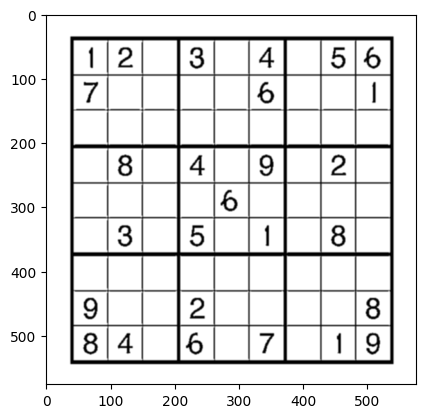

In [637]:
#image load
image = cv2.imread('testingImage.png',cv2.IMREAD_GRAYSCALE)
# Apply thresholding to convert to binary image


image=imagePreProcess(image)

plt.imshow(image,cmap='gray')

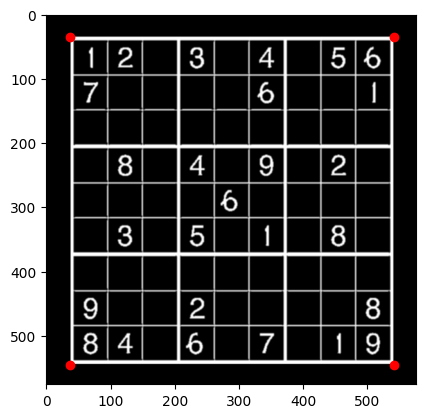

In [638]:
contour=findContourPoints(image)

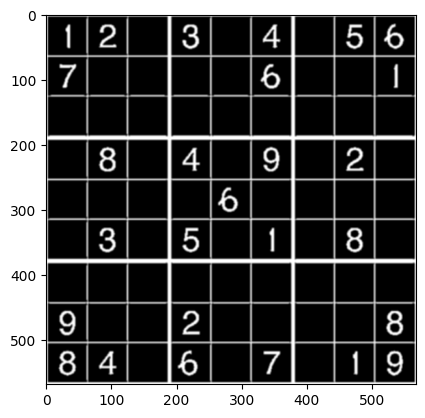

In [639]:
image=imageWrape(image,contour)

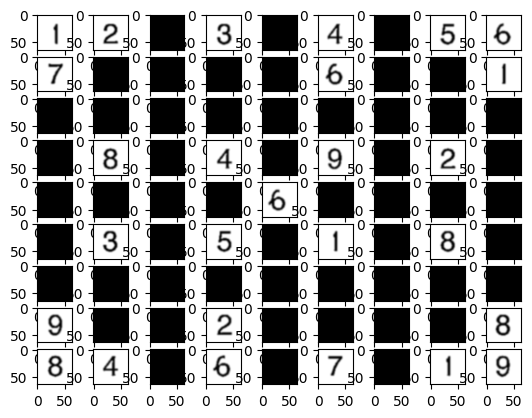

(9, 9, 64, 64)

In [640]:
imageList=imageSplit(image)
np.shape(imageList)

In [641]:
model=loadmodel()

In [642]:
result,accuracy=prediction(imageList,model)

0 |  0 | sum is 34191 |  predicted value is 1.0
0 |  1 | sum is 72618 |  predicted value is 2.0
0 |  2 | sum is 0 |  predicted value is 0.0
0 |  3 | sum is 77805 |  predicted value is 3.0
0 |  4 | sum is 0 |  predicted value is 0.0
0 |  5 | sum is 63951 |  predicted value is 4.0
0 |  6 | sum is 0 |  predicted value is 0.0
0 |  7 | sum is 77169 |  predicted value is 5.0
0 |  8 | sum is 77553 |  predicted value is 6.0
1 |  0 | sum is 53220 |  predicted value is 7.0
1 |  1 | sum is 0 |  predicted value is 0.0
1 |  2 | sum is 0 |  predicted value is 0.0
1 |  3 | sum is 0 |  predicted value is 0.0
1 |  4 | sum is 0 |  predicted value is 0.0
1 |  5 | sum is 81129 |  predicted value is 6.0
1 |  6 | sum is 0 |  predicted value is 0.0
1 |  7 | sum is 0 |  predicted value is 0.0
1 |  8 | sum is 32661 |  predicted value is 1.0
2 |  0 | sum is 0 |  predicted value is 0.0
2 |  1 | sum is 0 |  predicted value is 0.0
2 |  2 | sum is 0 |  predicted value is 0.0
2 |  3 | sum is 0 |  predicted value is 

In [643]:
print(result)



[[1. 2. 0. 3. 0. 4. 0. 5. 6.]
 [7. 0. 0. 0. 0. 6. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 8. 0. 4. 0. 9. 0. 2. 0.]
 [0. 0. 0. 0. 6. 0. 0. 0. 0.]
 [0. 3. 0. 5. 0. 1. 0. 8. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [9. 0. 0. 2. 0. 0. 0. 0. 8.]
 [8. 4. 0. 6. 0. 7. 0. 1. 9.]]


In [644]:
print(accuracy)

[[1.         0.99999166 0.         0.97277087 0.         0.98783374
  0.         0.99998307 0.99764878]
 [0.99906999 0.         0.         0.         0.         0.99566084
  0.         0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.98938304 0.         0.99641466 0.         0.98423833
  0.         0.99999309 0.        ]
 [0.         0.         0.         0.         0.98601139 0.
  0.         0.         0.        ]
 [0.         0.99731159 0.         0.99997711 0.         1.
  0.         0.90743756 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9150871  0.         0.         1.         0.         0.
  0.         0.         0.98080206]
 [0.96199334 0.99926847 0.         0.88202041 0.         0.99178678
  0.         1.         0.92635298]]
